In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os
from tensorflow.keras.applications import MobileNet
from keras.layers import Conv2D, MaxPooling2D, MaxPool2D, Flatten, Dense, Dropout, Activation, BatchNormalization, GlobalAveragePooling2D
from keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import plotly.figure_factory as ff

In [2]:
# Paths for training and testing datasets
train_path = "/kaggle/input/archive/train"
test_path = "/kaggle/input/archive/test"

IMG_HEIGHT = 48
IMG_WIDTH = 48
BATCH_SIZE = 64
EPOCHS = 40
LR = 0.0002
NUM_CLASSES = 7
PATIENCE = 4  # Early stopping patience
CLASS_LABELS = ['Surprise', 'Fear', 'Anger', 'Neutral', 'Sadness', 'Disgust', 'Happy']

In [3]:
# Data augmentation for training and validation
train_datagen = ImageDataGenerator(horizontal_flip=True,
                                   rescale=1./255,
                                   validation_split=0.2,
                                   rotation_range=10)

# Load training and validation data
train_generator = train_datagen.flow_from_directory(
                        directory=train_path,
                        target_size=(IMG_HEIGHT, IMG_WIDTH),
                        batch_size=BATCH_SIZE,
                        shuffle=True,
                        class_mode="categorical",
                        subset="training",
                        seed=12
                    )

validation_generator = train_datagen.flow_from_directory(
                        directory=train_path,
                        target_size=(IMG_HEIGHT, IMG_WIDTH),
                        batch_size=BATCH_SIZE,
                        shuffle=True,
                        class_mode="categorical",
                        subset="validation",
                        seed=12
                    )

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
                        directory=test_path,
                        target_size=(IMG_HEIGHT, IMG_WIDTH),
                        batch_size=BATCH_SIZE,
                        class_mode="categorical",
                        shuffle=False
                    )


Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [4]:
# Class distribution plot
ctg = os.listdir(train_path)
counts = []
for e in ctg:
    counts.append(len(os.listdir(train_path + f'/{e}')))
df_hist = pd.DataFrame()
df_hist['category'] = CLASS_LABELS
df_hist['count'] = counts
px.bar(df_hist, x='category', y='count')

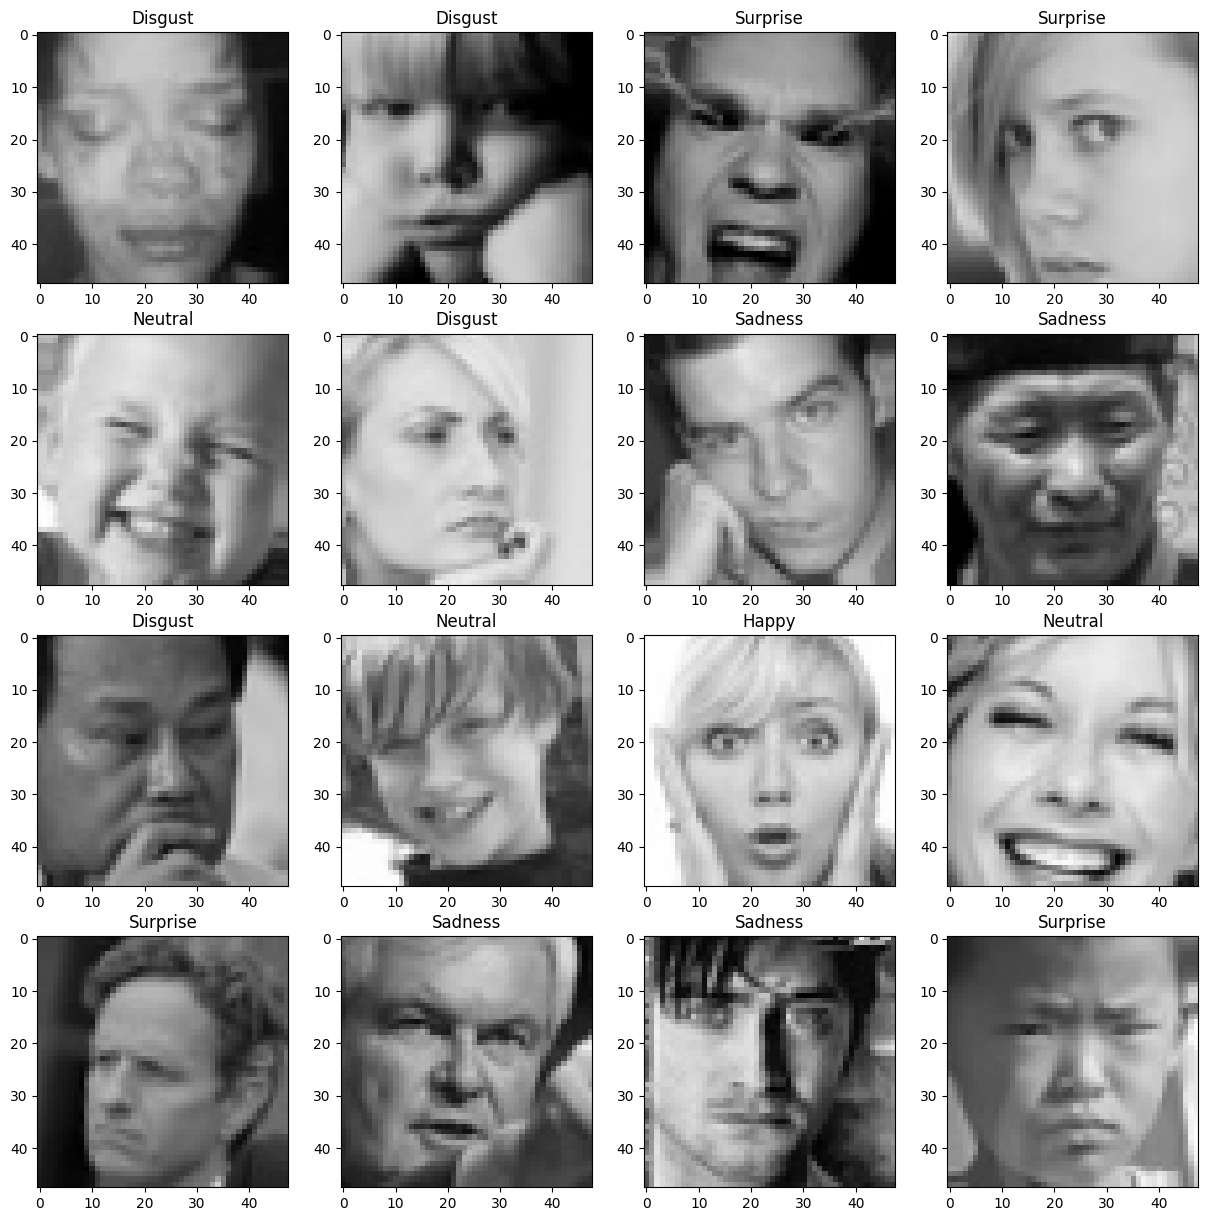

In [5]:
# Show a batch of images
imgs, labels = next(validation_generator)
validation_generator.reset()

plt.figure(figsize=(15, 15))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(imgs[i])
    plt.title(CLASS_LABELS[np.argmax(labels[i])])
plt.show()

In [6]:
# Resize image dimensions for pre-trained model (MobileNet)
IMG_HEIGHT = 224
IMG_WIDTH = 224

train_generator = train_datagen.flow_from_directory(
                        directory=train_path,
                        target_size=(IMG_HEIGHT, IMG_WIDTH),
                        batch_size=BATCH_SIZE,
                        shuffle=True,
                        class_mode="categorical",
                        subset="training",
                        seed=12
                    )

validation_generator = train_datagen.flow_from_directory(
                        directory=train_path,
                        target_size=(IMG_HEIGHT, IMG_WIDTH),
                        batch_size=BATCH_SIZE,
                        shuffle=True,
                        class_mode="categorical",
                        subset="validation",
                        seed=12
                    )
# Test generator
test_generator = test_datagen.flow_from_directory(
    directory=test_path,  # Specify your test dataset directory
    target_size=(IMG_HEIGHT, IMG_WIDTH),  # Resize to match MobileNet input
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False,  # Keep order for consistent evaluation
    seed=12
)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.


In [7]:
# Load MobileNet base model and freeze layers for pre-training
base_model = MobileNet(include_top=False, pooling='max', weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = False

x = base_model.layers[-2].output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
out = Dense(7, activation='softmax')(x)

pretrained_model = Model(inputs=base_model.input, outputs=out)

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [8]:
# Compile pre-trained model
pretrained_model.compile(
    optimizer=Adam(learning_rate=LR), 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

In [9]:
# Callbacks for early stopping and checkpoint saving
checkpoint = ModelCheckpoint("checkpoint_weights.keras", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)

CALLBACKS = [early_stopping, checkpoint]

In [10]:
# Train pre-trained model
history = pretrained_model.fit(
    x=train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=CALLBACKS
)

Epoch 1/40


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.

I0000 00:00:1734180400.839969     126 service.cc:145] XLA service 0x7ec0900021f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734180400.840028     126 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1734180400.840032     126 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  2/359 ━━━━━━━━━━━━━━━━━━━━ 19s 54ms/step - accuracy: 0.3164 - loss: 2.0667   

I0000 00:00:1734180410.331555     126 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 972ms/step - accuracy: 0.3415 - loss: 1.6803
Epoch 1: val_accuracy improved from -inf to 0.44452, saving model to checkpoint_weights.keras
359/359 ━━━━━━━━━━━━━━━━━━━━ 465s 1s/step - accuracy: 0.3417 - loss: 1.6799 - val_accuracy: 0.4445 - val_loss: 1.4379
Epoch 2/40
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 703ms/step - accuracy: 0.4747 - loss: 1.3911
Epoch 2: val_accuracy improved from 0.44452 to 0.47744, saving model to checkpoint_weights.keras
359/359 ━━━━━━━━━━━━━━━━━━━━ 322s 884ms/step - accuracy: 0.4747 - loss: 1.3911 - val_accuracy: 0.4774 - val_loss: 1.3720
Epoch 3/40
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 702ms/step - accuracy: 0.5046 - loss: 1.3198
Epoch 3: val_accuracy improved from 0.47744 to 0.48859, saving model to checkpoint_weights.keras
359/359 ━━━━━━━━━━━━━━━━━━━━ 321s 882ms/step - accuracy: 0.5046 - loss: 1.3198 - val_accuracy: 0.4886 - val_loss: 1.3402
Epoch 4/40
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 699ms/step - accuracy: 0.5219 - loss: 1.2702
Epoch 4: va

In [11]:
# Plot analysis for pre-trained model
def plot_analysis(m):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.plot(m.history['loss'], color="#E74C3C")
    plt.plot(m.history['val_loss'], color='#641E16')
    plt.title('Validation loss vs Train loss', fontsize=8)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')

    plt.subplot(1, 2, 2)
    plt.plot(m.history['accuracy'], color="#E74C3C")
    plt.plot(m.history['val_accuracy'], color='#641E16')
    plt.title('Validation accuracy vs Train accuracy', fontsize=8)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='lower right')

    plt.show()

In [12]:
# Save the pre-trained model
pretrained_model.save('./model/pretrained_model.h5')

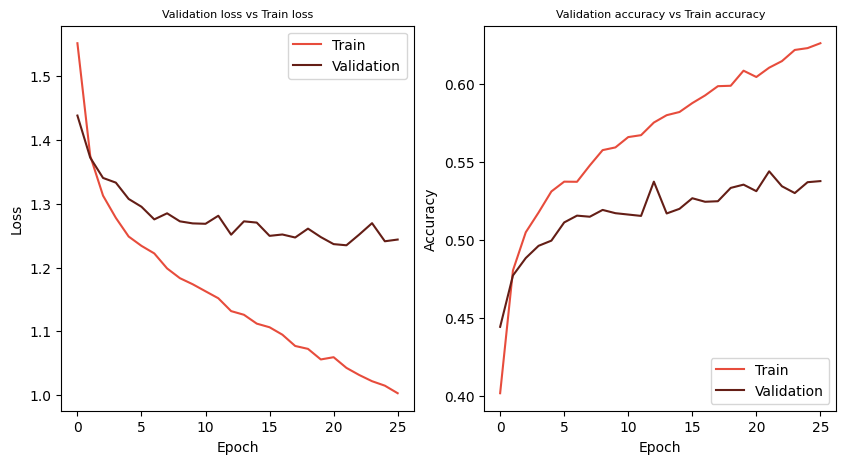

In [13]:
# Plot loss and accuracy
plot_analysis(history)

In [14]:
# Evaluate pre-trained model on test set
e = pretrained_model.evaluate(x=test_generator, verbose=1)

113/113 ━━━━━━━━━━━━━━━━━━━━ 66s 569ms/step - accuracy: 0.2027 - loss: 1.8901


In [16]:
test_generator = test_datagen.flow_from_directory(
    directory=test_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),  # Set to 224x224
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False,
)

Found 7178 images belonging to 7 classes.


In [17]:
# Generate confusion matrix and classification report for pre-trained model
test_generator.reset()
p = pretrained_model.predict(test_generator)
test_generator.reset()
labels_test = [CLASS_LABELS[item] for item in test_generator.labels]
labels_pred = [CLASS_LABELS[np.argmax(item)] for item in p]

# Print classification report
print(classification_report(labels_test, labels_pred))

113/113 ━━━━━━━━━━━━━━━━━━━━ 24s 198ms/step
              precision    recall  f1-score   support

       Anger       0.46      0.21      0.29      1024
     Disgust       0.48      0.40      0.43      1247
        Fear       0.47      0.19      0.27       111
       Happy       0.62      0.75      0.68       831
     Neutral       0.66      0.82      0.73      1774
     Sadness       0.45      0.60      0.51      1233
    Surprise       0.47      0.40      0.43       958

    accuracy                           0.55      7178
   macro avg       0.52      0.48      0.48      7178
weighted avg       0.53      0.55      0.53      7178



In [19]:
# Confusion matrix plot for pre-trained model
cfm = confusion_matrix(labels_test, labels_pred)
fig = ff.create_annotated_heatmap(np.flipud(cfm), x=CLASS_LABELS, y=list(np.flip(CLASS_LABELS)), colorscale='Purples')

fig.update_layout(
    title_text='<i><b>Confusion matrix (Pre-trained)</b></i>',
    xaxis=dict(title='Predicted label'),
    yaxis=dict(title='True label'),
    margin=dict(t=100, l=100),
    width=750,
    height=750
)
fig['data'][0]['showscale'] = True
fig.show()

In [20]:
# Fine-tuning the model (unfreeze base model layers)
base_model.trainable = True
finetunned_model = Model(inputs=base_model.input, outputs=out)

# Load best weights from checkpoint
finetunned_model.load_weights("/kaggle/working/checkpoint_weights.keras")

# Compile fine-tuned model
finetunned_model.compile(
    optimizer=Adam(learning_rate=LR),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train fine-tuned model
history = finetunned_model.fit(
    x=train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=CALLBACKS
)

Epoch 1/40
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 756ms/step - accuracy: 0.4824 - loss: 1.3890
Epoch 1: val_accuracy did not improve from 0.54416
359/359 ━━━━━━━━━━━━━━━━━━━━ 370s 942ms/step - accuracy: 0.4826 - loss: 1.3885 - val_accuracy: 0.5351 - val_loss: 1.1769
Epoch 2/40
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 706ms/step - accuracy: 0.6402 - loss: 0.9590
Epoch 2: val_accuracy improved from 0.54416 to 0.59467, saving model to checkpoint_weights.keras
359/359 ━━━━━━━━━━━━━━━━━━━━ 323s 886ms/step - accuracy: 0.6402 - loss: 0.9590 - val_accuracy: 0.5947 - val_loss: 1.1309
Epoch 3/40
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 707ms/step - accuracy: 0.6993 - loss: 0.8082
Epoch 3: val_accuracy did not improve from 0.59467
359/359 ━━━━━━━━━━━━━━━━━━━━ 323s 886ms/step - accuracy: 0.6992 - loss: 0.8082 - val_accuracy: 0.5804 - val_loss: 1.1306
Epoch 4/40
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 708ms/step - accuracy: 0.7394 - loss: 0.7108
Epoch 4: val_accuracy improved from 0.59467 to 0.62916, saving model to checkpoint_wei

In [21]:
# Save fine-tuned model
finetunned_model.save('./model/finetunned_model.h5')

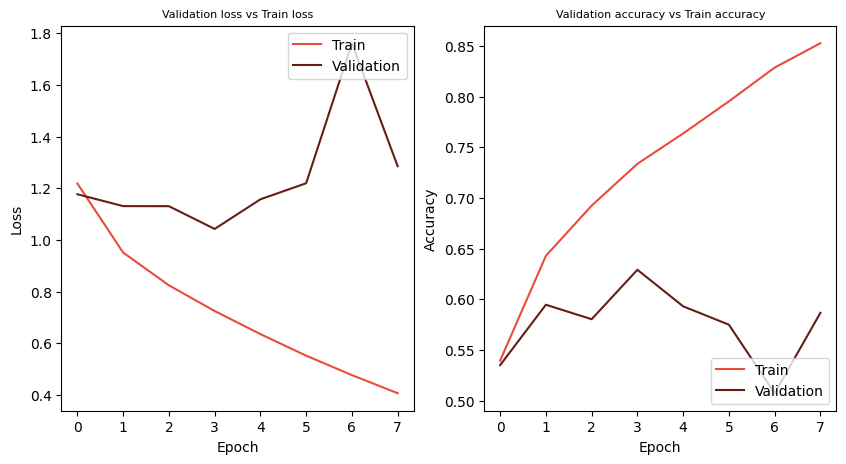

In [22]:
# Plot loss and accuracy for fine-tuned model
plot_analysis(history)

In [23]:
# Evaluate fine-tuned model on test set
e = finetunned_model.evaluate(x=test_generator, verbose=1)

113/113 ━━━━━━━━━━━━━━━━━━━━ 26s 233ms/step - accuracy: 0.5594 - loss: 1.2123


In [24]:
# Generate confusion matrix and classification report for fine-tuned model
test_generator.reset()
p = finetunned_model.predict(test_generator)
test_generator.reset()
labels_test = [CLASS_LABELS[item] for item in test_generator.labels]
labels_pred = [CLASS_LABELS[np.argmax(item)] for item in p]

# Print classification report
print(classification_report(labels_test, labels_pred))

113/113 ━━━━━━━━━━━━━━━━━━━━ 22s 185ms/step
              precision    recall  f1-score   support

       Anger       0.50      0.39      0.44      1024
     Disgust       0.54      0.49      0.52      1247
        Fear       0.50      0.59      0.54       111
       Happy       0.73      0.77      0.75       831
     Neutral       0.84      0.85      0.84      1774
     Sadness       0.50      0.73      0.59      1233
    Surprise       0.67      0.45      0.54       958

    accuracy                           0.63      7178
   macro avg       0.61      0.61      0.60      7178
weighted avg       0.64      0.63      0.63      7178



In [25]:
# Confusion matrix plot for fine-tuned model
cfm = confusion_matrix(labels_test, labels_pred)
fig = ff.create_annotated_heatmap(np.flipud(cfm), x=CLASS_LABELS, y=list(np.flip(CLASS_LABELS)), colorscale='Purples')

fig.update_layout(
    title_text='<i><b>Confusion matrix (Fine-tuned)</b></i>',
    xaxis=dict(title='Predicted label'),
    yaxis=dict(title='True label'),
    margin=dict(t=100, l=100),
    width=750,
    height=750
)
fig['data'][0]['showscale'] = True
fig.show()
